In [6]:
import ipywidgets as widgets
from traitlets import Unicode, validate

class KeyWidget(widgets.DOMWidget):
    _view_name = Unicode('KeyView').tag(sync=True)
    _view_module = Unicode('keyview').tag(sync=True)
    current_key = Unicode('nothing').tag(sync=True)
    

In [7]:
%%javascript
require.undef('keyview');

window.inputElement = undefined;

define('keyview', ["jupyter-js-widgets"], function(widgets) {

    var KeyView = widgets.DOMWidgetView.extend({
        render: function() {
            this.el.textContent = 'Press a key to tag the image below.';
            
            document.onkeydown = function(evt) {
                if (window.inputElement === undefined || window.inputElement !== document.activeElement) { return; }
                evt = evt || window.event;
                this.model.set("current_key", "None");
                this.touch();
                this.model.set("current_key", evt.key);
                this.touch();
            }.bind(this);
        }
    });

    return {
        KeyView: KeyView
    }
});

<IPython.core.display.Javascript object>

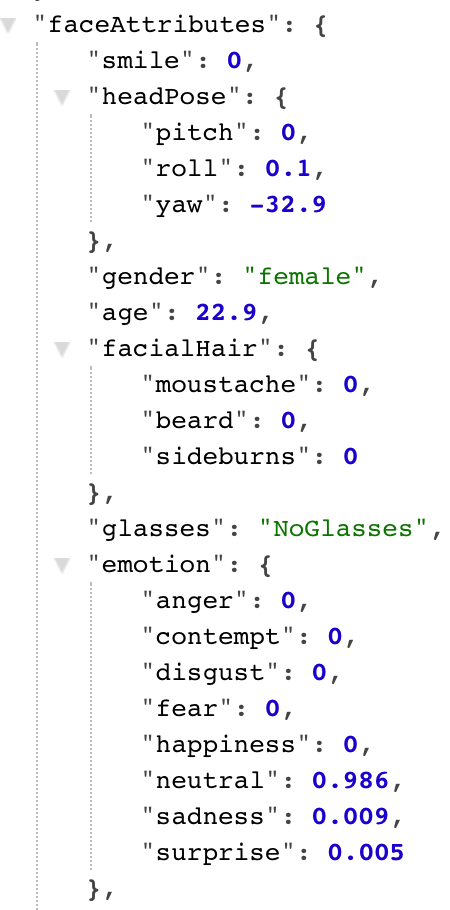

(!) Please tag this image first.
[At image 6 of 11
1: this, 2: that


In [8]:
from os import listdir
from os.path import isfile, join
from IPython.display import Image, display, clear_output, HTML
import time
import signal

tag_map = {
    "1": "this",
    "2": "that"
}
tag_legend = []
for key, value in tag_map.items(): tag_legend.append(key + ": " + value)

class TagInput:
    def __init__(self, key):
        self.key = key
        self.tag = tag_map[key] if (key in tag_map) else None
        self._isBack = key == "ArrowLeft"
        self._isForward = key == "ArrowRight"
        self._isExit = key == "Escape"
            
    def isBack(self):
        return self._isBack
    def isForward(self):
        return self._isForward
    def isExit(self):
        return self._isExit

def load_info(path):
    if not isfile(path):
        file = open(path, "w")
        file.close()
        return {}
    file = open(path, "r")
    lines = file.read().split("\n")
    file.close()
    dict = {}
    for i in range(0, len(lines) // 2):
        dict[lines[2*i]] = lines[2*i + 1]
    return dict

images_folder = "/Users/wircho/Desktop"
info_file_path = "/Users/wircho/Desktop/images_info.txt"
info = load_info(info_file_path)
file = open(info_file_path, "a")
deleted_info = {}
image_names = [f for f in listdir(images_folder) if isfile(join(images_folder, f)) and (f.endswith(".jpg") or f.endswith(".png"))]
num = len(image_names)
i = 0
warning = None
message = None
can_handle_tag_input = False
key_widget = KeyWidget()
display(key_widget)

def handle_key(change):
    if change.new is None or change.new == "None": return
    print("received a key: " + change.new)
    handle_tag_input(TagInput(change.new))

key_widget.observe(handle_key, names=["current_key"])

def prepare_for_next_image():
    global can_handle_tag_input
    while still_preparing(): pass
    can_handle_tag_input = True
    
def handle_tag_input(tag_input):
    global can_handle_tag_input
    if not can_handle_tag_input: return
    can_handle_tag_input = False
    if not should_continue(tag_input): return
    prepare_for_next_image()
    
def still_preparing():
    global i, warning, message, info, deleted_info, image_names, num, file, key_widget
    if i < 0: i = 0
    if i >= num: i = num - 1
    image_name = image_names[i]
    if i < num - 1 and image_name in info:
        i += 1
        return True
    clear_output()
    display(Image(join(images_folder, image_name), width = 200, height = 100))
    if not(message is None):
        print(message)
        message = None
    if not(warning is None):
        print("(!) " + warning)
        warning = None
    print("[At image " + str(i + 1) + "/" + str(num) + "]")
    print(", ".join(tag_legend))
    display(HTML("<input type='text' id='txt_field'/><script>window.inputElement = document.getElementById('txt_field'); window.inputElement.focus();</script>"))
    return False

def should_continue(tag_input):
    global i, warning, message, info, deleted_info, image_names, num, file
    image_name = image_names[i]
    if tag_input.isBack():
        if i <= 0:
            warning = "You're at the first image."
            return True
        prev_image_name = image_names[i - 1]
        if image_name in info:
            deleted_info[image_name] = info[image_name]
            del info[image_name]
        if prev_image_name in info:
            deleted_info[prev_image_name] = info[prev_image_name]
            del info[prev_image_name]
        i -= 1
    elif tag_input.isForward():
        if not(image_name in info) and image_name in deleted_info:
            info[image_name] = deleted_info[image_name]
        if not(image_name in info):
            warning = "Please tag this image first."
            return True
        if i >= num - 1:
            clear_output()
            print("You're done! :) Bye!")
            file.close()
            return False
        i += 1
    elif tag_input.isExit():
        clear_output()
        print("Ok! :) Bye!")
        file.close()
        return False
    elif not(tag_input.tag is None):
        info[image_name] = tag_input.tag
        file.write(image_name + "\n" + tag_input.tag + "\n")
        if i >= num - 1:
            clear_output()
            print("You're done! :) Bye!")
            file.close()
            return False
        i += 1
    else:
        warning = "Wrong tag (" + tag_input.key + "). Please try again."
    return True

prepare_for_next_image()

In [70]:
KeyWidget()